1. Loading and processing data 

In [48]:
import openmeteo_requests
import requests_cache
import pandas as pd
from retry_requests import retry
from sklearn.model_selection import cross_val_score, KFold, cross_val_predict
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, cohen_kappa_score, matthews_corrcoef
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier
import numpy as np
from datetime import datetime
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [25]:
# Setup the Open-Meteo API client with cache and retry on error
cache_session = requests_cache.CachedSession('.cache', expire_after = 3600)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)

# Make sure all required weather variables are listed here
# The order of variables in hourly or daily is important to assign them correctly below
url = "https://historical-forecast-api.open-meteo.com/v1/forecast"
params = {
    # melbourne coordinates
	"latitude": [-34.9287, -27.4679, -35.2835, -12.4611, -42.8794, -37.814, -33.8678, -31.9522],
	"longitude": [138.5986, 153.0281, 149.1281, 130.8418, 147.3294, 144.9633, 151.2073, 115.8614],
	"start_date": "2020-01-01",
	"end_date": "2024-12-25",
	"daily": ["weather_code", "temperature_2m_max", "temperature_2m_min", "uv_index_max", "precipitation_sum", "wind_speed_10m_max", "wind_gusts_10m_max"],
	"timezone": "Australia/Sydney"
}
responses = openmeteo.weather_api(url, params=params)

In [26]:
# Process first location. Add a for-loop for multiple locations or weather models

historical_data = dict()

for response in responses:
    # print(f"Coordinates {response.Latitude()}°N {response.Longitude()}°E")
    # print(f"Elevation {response.Elevation()} m asl")
    # print(f"Timezone {response.Timezone()} {response.TimezoneAbbreviation()}")
    # print(f"Timezone difference to GMT+0 {response.UtcOffsetSeconds()} s")
    daily = response.Daily()
    daily_weather_code = daily.Variables(0).ValuesAsNumpy()
    daily_temperature_2m_max = daily.Variables(1).ValuesAsNumpy()
    daily_temperature_2m_min = daily.Variables(2).ValuesAsNumpy()
    daily_uv_index_max = daily.Variables(3).ValuesAsNumpy()
    daily_precipitation_sum = daily.Variables(4).ValuesAsNumpy()
    daily_wind_speed_10m_max = daily.Variables(5).ValuesAsNumpy()
    daily_wind_gusts_10m_max = daily.Variables(6).ValuesAsNumpy()

    daily_data = {"date": pd.date_range(
        start = pd.to_datetime(daily.Time(), unit = "s", utc = True),
        end = pd.to_datetime(daily.TimeEnd(), unit = "s", utc = True),
        freq = pd.Timedelta(seconds = daily.Interval()),
        inclusive = "left"
    )}

    daily_data["weather_code"] = daily_weather_code
    daily_data["temperature_2m_max"] = daily_temperature_2m_max
    daily_data["temperature_2m_min"] = daily_temperature_2m_min
    daily_data["uv_index_max"] = daily_uv_index_max
    daily_data["precipitation_sum"] = daily_precipitation_sum
    daily_data["wind_speed_10m_max"] = daily_wind_speed_10m_max
    daily_data["wind_gusts_10m_max"] = daily_wind_gusts_10m_max
    daily_data["ave_temp"] = (daily_temperature_2m_max + daily_temperature_2m_min)/2

    daily_dataframe = pd.DataFrame(data = daily_data)
    historical_data[(response.Latitude(),response.Longitude())] = daily_dataframe


In [27]:
# convert historical data to a single dataframe
historical_df = pd.DataFrame()
for coord, data in historical_data.items():
    data = data.copy()
    historical_df = pd.concat([historical_df, data])

2. Cleaning data

In [28]:
# input features: sunrise, sunset, uv, precipitation, wind speed and gust
features = historical_df[["uv_index_max", "precipitation_sum", "wind_speed_10m_max", "wind_gusts_10m_max", "ave_temp", "weather_code"]]

# cannot use rows with missing features, so remove
missing_rows = features[features.isna().any(axis=1)]

# only train model using rows that contain all features
valid_rows = features[features.notna().all(axis=1)]

3a. Predicting temperature

In [29]:
# use cross validation to train, test and evaluate the model
X = valid_rows[["uv_index_max", "precipitation_sum", "wind_speed_10m_max", "wind_gusts_10m_max"]]
Y = valid_rows["ave_temp"]
temp_models = dict()

In [30]:
# model 0: baseline model mean

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
mean_prediction = np.mean(Y_train)
baseline_predictions = np.full_like(Y_test, mean_prediction, dtype=np.float64)
mse = mean_squared_error(Y_test, baseline_predictions)
r2 = r2_score(Y_test, baseline_predictions)

temp_models["model0"] = r2
print(f"Baseline Model Mean Squared Error: {mse:.4f}")
print(r2)

Baseline Model Mean Squared Error: 41.7109
-1.672191656676425e-05


In [31]:
# model 1: simple linear regression
model1 = LinearRegression()

# Set up cross-validation (e.g., 5-fold cross-validation)
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validation
scores = cross_val_score(model1, X, Y, cv=cv, scoring='r2')
predictions = cross_val_predict(model1, X, Y, cv=cv)

temp_models[model1] = float(np.mean(scores))
print(temp_models)

# Print cross-validation results
print("Cross-validation scores: ", scores)
print("Mean r2: ", np.mean(scores))
print("Standard deviation: ", np.std(scores))

results1 = pd.DataFrame({'Actual Values': Y, 'Predicted Values': predictions})
print(results1)

model1.fit(X, Y)


{'model0': -1.672191656676425e-05, LinearRegression(): 0.5058266282081604}
Cross-validation scores:  [0.48722249 0.50480413 0.51637506 0.5068208  0.51391065]
Mean r2:  0.5058266282081604
Standard deviation:  0.01024469295483534
      Actual Values  Predicted Values
448       18.865002         19.093201
449       18.065001         18.695984
450       18.465000         18.983181
451       18.115000         18.868795
452       17.340000         19.122814
...             ...               ...
1816      31.193001         24.764320
1817      31.993000         24.089233
1818      36.443001         24.255611
1819      25.768002         24.005646
1820      19.743000         23.600365

[10984 rows x 2 columns]


LinearRegression()

In [32]:
# model 2: random forest regressor
model2 = RandomForestRegressor()

# Set up cross-validation (e.g., 5-fold cross-validation)
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validation
scores = cross_val_score(model2, X, Y, cv=cv, scoring='r2')
predictions = cross_val_predict(model2, X, Y, cv=cv)

temp_models[model2] = float(np.mean(scores))

# Print cross-validation results
print("Cross-validation scores: ", scores)
print("Mean r2: ", np.mean(scores))
print("Standard deviation: ", np.std(scores))

results2 = pd.DataFrame({'Actual Values': Y, 'Predicted Values': predictions})
print(results2)

model2.fit(X, Y)

Cross-validation scores:  [0.53197991 0.52196831 0.56934769 0.55455237 0.56028   ]
Mean r2:  0.5476256573513585
Standard deviation:  0.017793524398029215
      Actual Values  Predicted Values
448       18.865002         17.282620
449       18.065001         17.515030
450       18.465000         20.323134
451       18.115000         17.223435
452       17.340000         16.773465
...             ...               ...
1816      31.193001         23.969251
1817      31.993000         26.569655
1818      36.443001         23.886700
1819      25.768002         25.194010
1820      19.743000         23.609976

[10984 rows x 2 columns]


RandomForestRegressor()

In [33]:
# model 3: KNN
model3 = KNeighborsRegressor()

# Set up cross-validation (e.g., 5-fold cross-validation)
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validation
scores = cross_val_score(model3, X, Y, cv=cv, scoring='r2')
predictions = cross_val_predict(model3, X, Y, cv=cv)

temp_models[model3] = float(np.mean(scores))

# Print cross-validation results
print("Cross-validation scores: ", scores)
print("Mean r2: ", np.mean(scores))
print("Standard deviation: ", np.std(scores))

results3 = pd.DataFrame({'Actual Values': Y, 'Predicted Values': predictions})
print(results3)

model3.fit(X, Y)

Cross-validation scores:  [0.47345573 0.47286397 0.51496756 0.50730062 0.52146137]
Mean r2:  0.4980098485946655
Standard deviation:  0.020780163979066728
      Actual Values  Predicted Values
448       18.865002         15.776400
449       18.065001         16.502201
450       18.465000         18.287500
451       18.115000         20.604900
452       17.340000         20.456398
...             ...               ...
1816      31.193001         21.578602
1817      31.993000         23.703899
1818      36.443001         23.583502
1819      25.768002         23.312399
1820      19.743000         21.425400

[10984 rows x 2 columns]


KNeighborsRegressor()

3b. Predicting weather codes

In [34]:
# use cross validation to train, test and evaluate the model
X = valid_rows[["uv_index_max", "precipitation_sum", "wind_speed_10m_max", "wind_gusts_10m_max"]]
Y = valid_rows["weather_code"]
weather_models = dict()

In [35]:
# model 0: Baseline Dummy Classifier

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
model0 = DummyClassifier() # uses the most frequent label
model0.fit(X_train, Y_train)
model0_predictions = model0.predict(X_test)
accuracy = accuracy_score(Y_test, model0_predictions)

weather_models["model0"] = accuracy

print(f"Baseline Model Accuracy: {accuracy:.4f}")

Baseline Model Accuracy: 0.3887


In [36]:
# model 1: Random Forest Classifier

model1 = RandomForestClassifier()

# Set up cross-validation (e.g., 5-fold cross-validation)
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validation
scores = cross_val_score(model1, X, Y, cv=cv, scoring='accuracy')
predictions = cross_val_predict(model1, X, Y, cv=cv)

weather_models[model1] = float(np.mean(scores))

# Print cross-validation results
print("Cross-validation scores: ", scores)
print("Mean accuracy: ", np.mean(scores))
print("Standard deviation: ", np.std(scores))

results1 = pd.DataFrame({'Actual Values': Y, 'Predicted Values': predictions})
print(results1)

model1.fit(X, Y)

Cross-validation scores:  [0.55575785 0.55439235 0.56121985 0.54893036 0.55965392]
Mean accuracy:  0.5559908651721631
Standard deviation:  0.004317880278916247
      Actual Values  Predicted Values
448            53.0              53.0
449            53.0              51.0
450            51.0              51.0
451            53.0              53.0
452             3.0               3.0
...             ...               ...
1816            1.0               3.0
1817            0.0               3.0
1818            2.0               2.0
1819            2.0               3.0
1820            2.0               3.0

[10984 rows x 2 columns]


RandomForestClassifier()

4. Determine best ML algorithm

In [37]:
def get_dict_key(dictionary, value):
    for key, val in dictionary.items():
        if value == val:
            return key

# best temp model is one with highest r2 score (regression)
best_temp_val = max(temp_models.values())
best_temp_model = get_dict_key(temp_models, best_temp_val)
print(best_temp_val)
print(best_temp_model)

# best weather code model is one with highest accuracy score (classifcation)
best_weather_val = max(weather_models.values())
best_weather_model = get_dict_key(weather_models, best_weather_val)
print(best_weather_val)
print(best_weather_model)


0.5476256573513585
RandomForestRegressor()
0.5559908651721631
RandomForestClassifier()


5. Forecasting temperature and weather code

In [38]:
# Get features for future dates: ["uv_index_max", "precipitation_sum", "wind_speed_10m_max", "wind_gusts_10m_max"]
# Compare to professional forcasting service ["ave temp", "weather code"] using our LinearRegression() and RandomForestClassifer()
# Do for all 7 capital cities of australia, then convert into 2 maps: 1 for our model, 1 for expert forecast, 7 day forecast

In [39]:
# Setup the Open-Meteo API client with cache and retry on error
cache_session = requests_cache.CachedSession('.cache', expire_after = 3600)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)

# Make sure all required weather variables are listed here
# The order of variables in hourly or daily is important to assign them correctly below
url = "https://api.open-meteo.com/v1/forecast"
params = {
	"latitude": [-34.9287, -27.4679, -35.2835, -12.4611, -42.8794, -37.814, -33.8678, -31.9522],
	"longitude": [138.5986, 153.0281, 149.1281, 130.8418, 147.3294, 144.9633, 151.2073, 115.8614],
	"daily": ["weather_code", "temperature_2m_max", "temperature_2m_min", "uv_index_max", "precipitation_sum", "wind_speed_10m_max", "wind_gusts_10m_max"],
	"timezone": "auto"
}
responses = openmeteo.weather_api(url, params=params)

In [40]:
# Process first location. Add a for-loop for multiple locations or weather models

cities_data = dict()

for response in responses:
    # print(f"Coordinates {response.Latitude()}°N {response.Longitude()}°E")
    # print(f"Elevation {response.Elevation()} m asl")
    # print(f"Timezone {response.Timezone()} {response.TimezoneAbbreviation()}")
    # print(f"Timezone difference to GMT+0 {response.UtcOffsetSeconds()} s")

    # Process daily data. The order of variables needs to be the same as requested.
    daily = response.Daily()
    daily_weather_code = daily.Variables(0).ValuesAsNumpy()
    daily_temperature_2m_max = daily.Variables(1).ValuesAsNumpy()
    daily_temperature_2m_min = daily.Variables(2).ValuesAsNumpy()
    daily_uv_index_max = daily.Variables(3).ValuesAsNumpy()
    daily_precipitation_sum = daily.Variables(4).ValuesAsNumpy()
    daily_wind_speed_10m_max = daily.Variables(5).ValuesAsNumpy()
    daily_wind_gusts_10m_max = daily.Variables(6).ValuesAsNumpy()

    daily_data = {"date": pd.date_range(
        start = pd.to_datetime(daily.Time(), unit = "s", utc = True),
        end = pd.to_datetime(daily.TimeEnd(), unit = "s", utc = True),
        freq = pd.Timedelta(seconds = daily.Interval()),
        inclusive = "left"
    )}
    daily_data["weather_code"] = daily_weather_code
    daily_data["ave_temp"] = (daily_temperature_2m_max + daily_temperature_2m_min) / 2
    daily_data["uv_index_max"] = daily_uv_index_max
    daily_data["precipitation_sum"] = daily_precipitation_sum
    daily_data["wind_speed_10m_max"] = daily_wind_speed_10m_max
    daily_data["wind_gusts_10m_max"] = daily_wind_gusts_10m_max

    daily_dataframe = pd.DataFrame(data = daily_data)

    # input features
    X = daily_dataframe[["uv_index_max", "precipitation_sum", "wind_speed_10m_max", "wind_gusts_10m_max"]]

    # add 2 columns to each capital city df for our predicted temp (LR) and weather (RF) code
    daily_dataframe["RFR_temp"] = best_temp_model.predict(X)
    daily_dataframe["RFC_code"] = best_weather_model.predict(X)

    # extract relevant columns
    city_data = daily_dataframe[["date", "weather_code", "ave_temp", "RFR_temp", "RFC_code"]]
    cities_data[(response.Latitude(), response.Longitude())] = city_data

In [41]:
# export to csv to visualise in PowerBI
output = pd.DataFrame()

for coord, data in cities_data.items():
    data = data.copy()
    data["location"] = str(coord)
    output = pd.concat([output, data])

# remove time component of output
output["date"] = pd.to_datetime(output["date"]).dt.date

output = output[["location", "date", "weather_code", "ave_temp", "RFR_temp", "RFC_code"]].reset_index(drop=True)
output.to_csv("output.csv", index=False)

6. Statistical analysis

In [45]:
# Comparing expert to RFR temp forecasts
r2 = r2_score(output["ave_temp"], output["RFR_temp"])
mae = mean_absolute_error(output["ave_temp"], output["RFR_temp"])
mse = mean_squared_error(output["ave_temp"], output["RFR_temp"])

print((r2, mae, mse))

(-0.011888176680792117, 3.758491273692676, 22.15779571914141)


[ 0.  2.  3. 61. 63. 80. 95. 96.  1.]
[ 3. 45. 80.  2.  1. 95. 51.]


c:\Users\Du-Simon Nguyen\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Du-Simon Nguyen\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


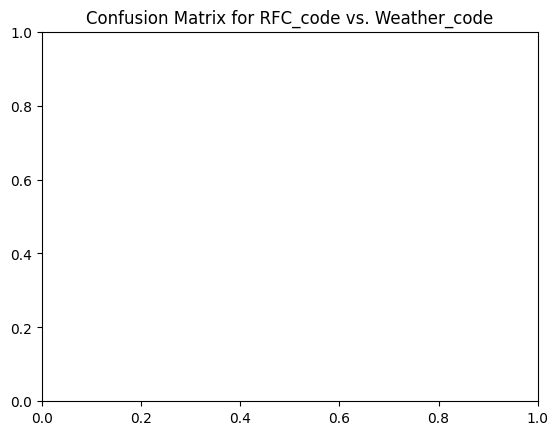

Accuracy: 0.48214285714285715
Precision: 0.43406593406593397
Recall: 0.48214285714285715
F1 Score: 0.4454362507253355
Confusion Matrix:
 [[ 0  0  0  1  0  0  0  0  0  0  0]
 [ 0  0  1  1  0  0  0  0  0  0  0]
 [ 0  0  1  8  1  0  0  0  0  0  0]
 [ 0  1  3 20  2  0  0  0  2  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  1  0  0]
 [ 0  0  0  0  0  0  0  0  1  0  0]
 [ 0  0  0  0  0  1  0  0  5  0  0]
 [ 0  0  0  0  0  0  0  0  3  1  0]
 [ 0  0  0  0  0  0  0  0  1  2  0]]


In [ ]:
# Comparing expert to RFC weather codes
accuracy = accuracy_score(output['weather_code'], output['RFC_code'])
precision = precision_score(output['weather_code'], output['RFC_code'], average='weighted')
recall = recall_score(output['weather_code'], output['RFC_code'], average='weighted')
f1 = f1_score(output['weather_code'], output['RFC_code'], average='weighted')
conf_matrix = confusion_matrix(output['weather_code'], output['RFC_code'])

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Confusion Matrix:\n", conf_matrix)


